# Identify when a record begins based on data availability.

## Code!

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

import xesmf as xe

%matplotlib inline

### Collect file paths.

In [2]:
obslens_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'

#### Collect GISTEMP 5x5 file paths.

In [3]:
gistemp_5x5_files = glob.glob('%s/GISTEMP_5x5/20240820/xagg_correctedtime/ensembleChunk_5x5_????.nc' % obslens_tseries_dir)
gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [4]:
hadcrut5_files = glob.glob('%s/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.analysis.anomalies.*.nc' % obslens_tseries_dir)
hadcrut5_files = [i for i in hadcrut5_files if "Trends" not in i]
hadcrut5_files.sort()

#### Collect DCENT unfilled file paths.

In [5]:
dcent_unfilled_files = glob.glob('%s/DCENT/20240901/xagg/DCENT_ensemble_1850_2023_member_???.nc' % obslens_tseries_dir)
dcent_unfilled_files = [i for i in dcent_unfilled_files if "Trends" not in i]
dcent_unfilled_files.sort()

#### BEST file paths

In [6]:
best_files = [f"{obslens_tseries_dir}/BEST/20250320/xagg/Land_and_Ocean_LatLong1.nc"]

## Identify a start year based on data availability

Less conservative annual averaging.  
To quote Lenssen et al. (2019) "To have coverage for a year it must have coverage for at least three seasons, which requires at least 2 months in the season.”

In [7]:
def annual_data(
    ds: xr.DataArray,
    season_threshold: int=3,
    intraseason_threshold: int=2,
):
    """
    Mask data if any season is missing more than one month.
    To quote Lenssen et al. (2019) "To have coverage for a year it must have coverage for at least 
    three seasons, which requires at least 2 months in the season.”

    Args:
        ds (xr.DataArray): Input data

    Returns:
        ds (xr.DataArray): Mask of availability!
    """
    availability = ds["time.season"].where(~np.isnan(ds))
    
    complete_seasons = 0
    seasons = ["DJF", "MAM", "JJA", "SON"]
    for _szn in seasons:
        complete_seasons += ((availability == _szn).sum(dim="time") >= intraseason_threshold)
        
    return complete_seasons >= season_threshold

The simplest approach excludes too much data!

In [8]:
def startyear1(
    data_annual: xr.DataArray,
):
    """_summary_

    Args:
        data_annual (xr.DataArray): Actual data in an annual mean resolution. Remember use skipna=False!

    Returns:
        startyear_full: xarray DataArray with the start year for each region.
    """
    # Compute the last nan year and step one year forward.
    startyear = data_annual["year"].where(np.isnan(data_annual)).max(dim="year") + 1

    complete_tseries = ~np.isnan(data_annual).any(dim="year") # Identify regions without any nans
    absent_tseries = (startyear == data_annual.year[-1]) | (startyear == data_annual.year[-1] + 1) # Identify regions with all nans

    # Set the complete years to the record start year
    startyear_full = xr.where(complete_tseries, data_annual.year[0], startyear)
    # Set the years with consistent missing data to no start year
    startyear_full = xr.where(absent_tseries, np.nan, startyear_full)
    
    return startyear_full

This approach looks for availability for windows of various lengths beginning in the start year. It seems to work best because data gaps become less important as the record becomes longer.

In [9]:
def startyear_running_availability(
    mask_annual: xr.DataArray,
    windows: list = [5, 10, 20, 40, 80],
    fraction: float = 0.6666,
    fillvalue: int = 2100,
):
    """
    This function identifies start years from a Boolean mask indicating 
    annual data availability input using two conditions:
        1. The data is present during the startyear.
        2. There is at least "fraction" data availability for windows of length "windows".

    Args:
        data_annual (xr.DataArray): Boolean mask in an annual mean resolution. i.e. Produced by annual_mask()
        windows (list, optional): Window lengths to test.
        fraction (float, optional): Fraction of data availability needed for a window to be considered available.
        fillvalue (int, optional): Real values to fill when a startdate is not detected. Defaults to 2100.

    Returns:
        startyear: xarray DataArray with the start year for each region.
    """

    # Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
    # True if year represents the beginning of a window with coverage >= fraction.
    cumulative_avail_mask = mask_annual
    for _length in windows:
        _avail_mask = (mask_annual.rolling(
                dim={"year": _length},
                center=False,
            ).sum() >= _length * fraction
        ).shift(year=1 - _length, fill_value=True) # Shift so labelled by start and fill nans when incomplete
        cumulative_avail_mask = cumulative_avail_mask & _avail_mask

    startyear = mask_annual["year"].where(cumulative_avail_mask).min(dim="year")
    startyear = startyear.where(cumulative_avail_mask.any(dim="year"), fillvalue) # Fill nans if no available gaps

    return startyear

In [10]:
def multidim_groupby_map(
    data,
    groupby_dims,
    ffunc,
    **ffunc_kwargs,
):
    '''
    Hilarious recursive solution for the xarray groupby multiple dimensions problem. 
    xarray groupby objects cannot be grouped again, but you can map a function that does group them again.
    The base case is that we are grouping by a single dimension, which xarray can handle.
    Otherwise we groupby a new dimension and call our function on the remaining dimensions.
    
    Pass data as an xarray.DataArray, groupby_dims as a list, ffunc as the final function to apply,
    and ffunc_kwargs as arguments for ffunc.
    '''
    if len(groupby_dims)==1:
        return data.groupby(groupby_dims[0]).map(ffunc,**ffunc_kwargs) # using groupby_dims.pop() instead of groupby_dims[0] didn't work for some reason
    return data.groupby(groupby_dims.pop()).map(multidim_groupby_map,groupby_dims=groupby_dims,ffunc=ffunc,**ffunc_kwargs)


def annual_average_from_seasonal_averages(
    data: xr.DataArray,
):
    """Produce annual averages that weight seasons equally even if individual months are missing. 

    Args:
        data (xr.DataArray): Data with a time dimension that can be grouped using
        time.year and time.season.

    Returns:
        annual_avg (xr.DataArray): Averaged data
    """
    
    annual_avg = multidim_groupby_map(
        data,
        groupby_dims=["time.year", "time.season"],
        ffunc=xr.DataArray.mean,
        skipna=True,
        dim=["time"],
    ).mean(dim="season")
    
    return annual_avg


def reindex_time_by_startyear(
    data_ann_avg: xr.DataArray,
    startyears: xr.DataArray,
    stack_vars: list = None,
    spatial_str: str = "z"
):
    """Reindex the temporal dimension so records begin according to a supplied array of start years.

    Args:
        data_ann_avg (xr.DataArray): Annually averaged data with a "year" time dimension.
        startyears (xr.DataArray): Array of start years for the spatial dimensions of the data.
        stack_vars (list, optional): If the spatial dimensions are more than 1, pass them here.. Defaults to None.
        spatial_str (str, optional): Variable to assigned stacked spatial fields. Defaults to "z".

    Returns:
        xr.DataArray: Appropriately reindexed data with new time dimension "recordlength".
    """
    
    # This doesn't work yet but it should eventually.
    if stack_vars is not None:
        data_stacked = data_ann_avg.stack({spatial_str: stack_vars})
        startyears_stacked = startyears.stack({spatial_str: stack_vars})
    else:
        data_stacked = data_ann_avg
        startyears_stacked = startyears

    combino_list = []
    for _spatial_startyear in startyears_stacked:
        time_subset = data_stacked.sel(
            {spatial_str: _spatial_startyear[spatial_str],
             "year": slice(_spatial_startyear, None),
             },
        )

        durations = np.arange(1, time_subset.year.shape[0] + 1)
        
        time_subset = time_subset.rename({"year": "recordlength"}).assign_coords(recordlength=durations)
        combino_list.append(time_subset)

    tseries_indexed_by_duration = xr.combine_nested(
        combino_list,
        concat_dim=[spatial_str],
    )
    if stack_vars is not None:
        # Need to apply the multi-index again for some reason to be able to unstack.
        tseries_indexed_by_duration = tseries_indexed_by_duration.set_index({spatial_str: stack_vars}).unstack("z")
    
    return tseries_indexed_by_duration

## Compute internally consistent start dates for each data product.

Compute the startdate for each ensemble member and take the latest one.

In [11]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
dcent_unfilled_tas_var = "temperature"
best_tas_var = "temperature"

#### GISTEMP

It is weird the GISTEMP has availability in Antarctica and confidence in it...but actually it agrees pretty well with HadCRUT5.

E. Antarctica: 1960 (1957)  
W. Antarctica: 1984 (never)  
Arctic Ocean: 1931 (1933)  

In [11]:
earliest_startyear = 1900
fillvalue = 2100
gistemp_startyear_list = []
gistemp_availability_list = []
for i, _file in enumerate(gistemp_5x5_files):
    print(i, end=" ")
    _gistemp_ds = xr.open_dataset(_file)[gistemp_tas_var].sel(time=slice(None,"2020"))
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _gistemp_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    gistemp_startyear_list.append(_realization_startyears)
    gistemp_availability_list.append(_availability_mask)
    # break

del _gistemp_ds
gistemp_startyears = xr.concat(gistemp_startyear_list, dim="realization")
gistemp_availability = xr.concat(gistemp_availability_list, dim="realization")
gistemp_startyear_mid = gistemp_startyears.quantile(0.75, dim="realization")
# Set values less than 1900 to 1900.
gistemp_startyear_final = xr.where(
    gistemp_startyear_mid > earliest_startyear,
    gistemp_startyear_mid, 
    earliest_startyear,
)
gistemp_startyear_final = gistemp_startyear_final.where(gistemp_startyear_final != fillvalue) # Revert masking to a nan
del gistemp_startyear_mid, gistemp_startyear_list, gistemp_availability_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [12]:
# Now iterate over the files and re-index them!

gistemp_reindexed_list = []
for i, _file in enumerate(gistemp_5x5_files):
    print(i, end=" ")
    _gistemp_ds = xr.open_dataset(_file)[gistemp_tas_var].sel(time=slice(None,"2020"))
    _mask = gistemp_availability.sel(realization=_gistemp_ds.realization)
    
    _gistemp_ann_avg = annual_average_from_seasonal_averages(_gistemp_ds).where(_mask)

    _gistemp_reindex = reindex_time_by_startyear(
        data_ann_avg=_gistemp_ann_avg,
        startyears=gistemp_startyear_final,
        spatial_str="RegionIndex",
    )
    gistemp_reindexed_list.append(_gistemp_reindex)
    # if i == 2: break
gistemp_reindexed = xr.concat(gistemp_reindexed_list, dim="realization")
# del _gistemp_ds, gistemp_reindexed_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [13]:
gistemp_reindexed.to_netcdf(f"{obslens_tseries_dir}/GISTEMP_5x5/20240820/xagg_correctedtime/ensembleChunks_0001_0200.reindexed.IPCCRegions.190001-202012.nc")
gistemp_availability.to_netcdf(f"{obslens_tseries_dir}/GISTEMP_5x5/20240820/xagg_correctedtime/ensembleChunks_0001_0200.availability.IPCCRegions.190001-202012.nc")
gistemp_startyears.to_netcdf(f"{obslens_tseries_dir}/GISTEMP_5x5/20240820/xagg_correctedtime/ensembleChunks_0001_0200.startyears.IPCCRegions.190001-202012.nc")

In [14]:
del gistemp_reindexed, gistemp_availability

#### HadCRUT5

In [15]:
earliest_startyear = 1900
fillvalue = 2100
hadcrut5_startyear_list = []
hadcrut5_availability_list = []
for i, _file in enumerate(hadcrut5_files):
    print(i, end=" ")
    _hadcrut5_ds = xr.open_dataset(_file)[hadcrut5_tas_var].sel(time=slice(None,"2020"))
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _hadcrut5_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    hadcrut5_startyear_list.append(_realization_startyears)
    hadcrut5_availability_list.append(_availability_mask)

del _hadcrut5_ds
hadcrut5_startyears = xr.concat(hadcrut5_startyear_list, dim="realization")
hadcrut5_availability = xr.concat(hadcrut5_availability_list, dim="realization")
hadcrut5_startyear_mid = hadcrut5_startyears.quantile(0.75, dim="realization")
# Set values less than 1900 to 1900.
hadcrut5_startyear_final = xr.where(
    hadcrut5_startyear_mid > earliest_startyear,
    hadcrut5_startyear_mid, 
    earliest_startyear,
)
hadcrut5_startyear_final = hadcrut5_startyear_final.where(hadcrut5_startyear_final != fillvalue) # Revert masking to a nan
del hadcrut5_startyear_mid, hadcrut5_startyear_list, hadcrut5_availability_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [16]:
# Now iterate over the files and re-index them!

hadcrut5_reindexed_list = []
for i, _file in enumerate(hadcrut5_files):
    print(i, end=" ")
    _hadcrut5_ds = xr.open_dataset(_file)[hadcrut5_tas_var].sel(time=slice(None,"2020"))
    _mask = hadcrut5_availability.sel(realization=_hadcrut5_ds.realization)
    
    _hadcrut5_ann_avg = annual_average_from_seasonal_averages(_hadcrut5_ds).where(_mask)

    _hadcrut5_reindex = reindex_time_by_startyear(
        data_ann_avg=_hadcrut5_ann_avg,
        startyears=hadcrut5_startyear_final,
        spatial_str="RegionIndex",
    )
    hadcrut5_reindexed_list.append(_hadcrut5_reindex)
    # if i == 2: break
hadcrut5_reindexed = xr.concat(hadcrut5_reindexed_list, dim="realization")
hadcrut5_reindexed = hadcrut5_reindexed.sortby("realization")

del _hadcrut5_ds, hadcrut5_reindexed_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [17]:
# Save
hadcrut5_reindexed.to_netcdf(f"{obslens_tseries_dir}/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.001_200.reindexed.IPCCRegions.190001-202412.nc")
hadcrut5_availability.to_netcdf(f"{obslens_tseries_dir}/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.001_0200.availability.IPCCRegions.190001-202412.nc")
hadcrut5_startyears.to_netcdf(f"{obslens_tseries_dir}/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.001_0200.startyears.IPCCRegions.190001-202412.nc")

In [18]:
del hadcrut5_reindexed, hadcrut5_availability

#### DCENT

In [ ]:
earliest_startyear = 1900
fillvalue = 2100
dcent_unfilled_startyear_list = []
dcent_unfilled_availability_list = []
for i, _file in enumerate(dcent_unfilled_files):
    print(i, end=" ")
    _dcent_ds = xr.open_dataset(_file)[dcent_unfilled_tas_var].sel(time=slice(None,"2020"))
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _dcent_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    dcent_unfilled_startyear_list.append(_realization_startyears)
    dcent_unfilled_availability_list.append(_availability_mask)

del _dcent_ds
dcent_unfilled_startyears = xr.concat(dcent_unfilled_startyear_list, dim="realization")
dcent_unfilled_availability = xr.concat(dcent_unfilled_availability_list, dim="realization")
dcent_unfilled_startyear_mid = dcent_unfilled_startyears.quantile(0.75, dim="realization")
# Set values less than 1900 to 1900.
dcent_unfilled_startyear_final = xr.where(
    dcent_unfilled_startyear_mid > earliest_startyear,
    dcent_unfilled_startyear_mid, 
    earliest_startyear,
)
dcent_unfilled_startyear_final = dcent_unfilled_startyear_final.where(dcent_unfilled_startyear_final != fillvalue) # Revert masking to a nan
del dcent_unfilled_startyear_mid, dcent_unfilled_startyear_list, dcent_unfilled_availability_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [20]:
# Now iterate over the files and re-index them!

dcent_unfilled_reindexed_list = []
for i, _file in enumerate(dcent_unfilled_files):
    print(i, end=" ")
    _dcent_ds = xr.open_dataset(_file)[dcent_unfilled_tas_var].sel(time=slice(None,"2020"))
    _mask = dcent_unfilled_availability.sel(realization=_dcent_ds.realization)
    
    _dcent_unfilled_ann_avg = annual_average_from_seasonal_averages(_dcent_ds).where(_mask)

    _dcent_unfilled_reindex = reindex_time_by_startyear(
        data_ann_avg=_dcent_unfilled_ann_avg,
        startyears=dcent_unfilled_startyear_final,
        spatial_str="RegionIndex",
    )
    dcent_unfilled_reindexed_list.append(_dcent_unfilled_reindex)
    # if i == 2: break
dcent_unfilled_reindexed = xr.concat(dcent_unfilled_reindexed_list, dim="realization")
dcent_unfilled_reindexed = dcent_unfilled_reindexed.sortby("realization")

del _dcent_ds, dcent_unfilled_reindexed_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [21]:
# Save
dcent_unfilled_reindexed.to_netcdf(f"{obslens_tseries_dir}/DCENT/20240901/xagg/DCENT_ensemble_1850_2023.001_200.reindexed.IPCCRegions.190001-202312.nc")
dcent_unfilled_availability.to_netcdf(f"{obslens_tseries_dir}/DCENT/20240901/xagg/DCENT_ensemble_1850_2023.001_200.availability.IPCCRegions.190001-202312.nc")
dcent_unfilled_startyears.to_netcdf(f"{obslens_tseries_dir}/DCENT/20240901/xagg/DCENT_ensemble_1850_2023.001_200.startyears.IPCCRegions.190001-202312.nc")

In [22]:
del dcent_unfilled_reindexed, dcent_unfilled_availability

#### BEST

In [19]:
earliest_startyear = 1900
fillvalue = 2100
best_startyear_list = []
best_availability_list = []
for i, _file in enumerate(best_files):
    print(i, end=" ")
    _best_ds = xr.open_dataset(_file)[best_tas_var].sel(time=slice(None,"2020"))
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _best_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    best_startyear_list.append(_realization_startyears)
    best_availability_list.append(_availability_mask)

del _best_ds
best_startyears = xr.concat(best_startyear_list, dim="realization")
best_availability = xr.concat(best_availability_list, dim="realization")
best_startyear_mid = best_startyears.quantile(0.75, dim="realization")
# Set values less than 1900 to 1900.
best_startyear_final = xr.where(
    best_startyear_mid > earliest_startyear,
    best_startyear_mid, 
    earliest_startyear,
)
best_startyear_final = best_startyear_final.where(best_startyear_final != fillvalue) # Revert masking to a nan
del best_startyear_mid, best_startyear_list, best_availability_list

0 

With start years >= 1900.

In [ ]:
# Now iterate over the files and re-index them!

best_reindexed_list = []
for i, _file in enumerate(best_files):
    print(i, end=" ")
    _best_ds = xr.open_dataset(_file)[best_tas_var].sel(time=slice(None,"2020"))
    _mask = best_availability.sel(realization=i)
    
    _best_ann_avg = annual_average_from_seasonal_averages(_best_ds).where(_mask)

    _best_reindex = reindex_time_by_startyear(
        data_ann_avg=_best_ann_avg,
        startyears=best_startyear_final,
        spatial_str="RegionIndex",
    )
    best_reindexed_list.append(_best_reindex)
    # if i == 2: break
best_reindexed = xr.concat(best_reindexed_list, dim="realization")
best_reindexed = best_reindexed.sortby("realization")

del _best_ds, best_reindexed_list

0 

With start years whenever.

In [ ]:
# Now iterate over the files and re-index them!

best_reindexed_list = []
for i, _file in enumerate(best_files):
    print(i, end=" ")
    _best_ds = xr.open_dataset(_file)[best_tas_var].sel(time=slice(None,"2020"))
    _mask = best_availability.sel(realization=i)
    
    _best_ann_avg = annual_average_from_seasonal_averages(_best_ds).where(_mask)

    _best_reindex = reindex_time_by_startyear(
        data_ann_avg=_best_ann_avg,
        startyears=best_startyears,
        spatial_str="RegionIndex",
    )
    best_reindexed_list.append(_best_reindex)
    # if i == 2: break
best_whenever_reindexed = xr.concat(best_reindexed_list, dim="realization")
best_whenever_reindexed = best_whenever_reindexed.sortby("realization")

del _best_ds, best_reindexed_list

In [ ]:
# Save
best_reindexed.to_netcdf(f"{obslens_tseries_dir}/BEST/20250320/xagg/Land_and_Ocean_LatLong1.reindexed.IPCCRegions.190001-202012.nc")
best_whenever_reindexed.to_netcdf(f"{obslens_tseries_dir}/BEST/20250320/xagg/Land_and_Ocean_LatLong1.pre1900reindexed.IPCCRegions.190001-202012.nc")
best_availability.to_netcdf(f"{obslens_tseries_dir}/BEST/20250320/xagg/Land_and_Ocean_LatLong1.availability.IPCCRegions.190001-202012.nc")
best_startyears.to_netcdf(f"{obslens_tseries_dir}/BEST/20250320/xagg/Land_and_Ocean_LatLong1.startyears.IPCCRegions.190001-202012.nc")

In [ ]:
del best_reindexed, best_availability

## Repeat start year calculating and re-indexing for 5x5 deg. data

In [12]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
dcent_unfilled_tas_var = "temperature"
best_tas_var = "temperature"

In [13]:
gistemp_2x2_dir = '/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Aug/' # I don't want to use this
gistemp_dir = "/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Aug_5x5/"
hadcrut5_dir = '/glade/derecho/scratch/lenssen/data4jonah/HadCRUT5_Ensemble_Aug/'
dcent_unfilled_dir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/DCENT/rawdata/DCENT_ensemble/"
best_dir = "/glade/u/home/jonahshaw/w/obs/BEST/" # Land_and_Ocean_LatLong1.nc

### Collect file paths.

#### Collect GISTEMP file paths.

In [14]:
gistemp_files = glob.glob('%s/ensembleChunk_5x5_????.nc' % gistemp_dir)
gistemp_files.sort()

#### Collect HadCRUT5 file paths.

In [15]:
hadcrut5_files = glob.glob('%s/HadCRUT.5.0.2.0.analysis.anomalies.*.nc' % hadcrut5_dir)
hadcrut5_files.sort()

#### Collect DCENT (unfilled) file paths.

In [16]:
dcent_unfilled_files = glob.glob('%s/DCENT_ensemble_1850_2023_member_???.nc' % dcent_unfilled_dir)
dcent_unfilled_files.sort()

#### Collect BEST file paths

In [17]:
best_files = glob.glob(f"{best_dir}/Land_and_Ocean_LatLong1.nc")

## GISTEMP

In [28]:
earliest_startyear = 1900
fillvalue = 2100
gistemp_startyear_list = []
gistemp_availability_list = []

new_times = pd.date_range('1880-01-16', '2020-12-31', freq='1ME') + pd.tseries.offsets.Day(-15)

for i, _file in enumerate(gistemp_files):
    print(i, end=" ")
    _gistemp_ds = xr.open_dataset(_file).rename({"latitude": "lat", "longitude": "lon"})[gistemp_tas_var]
    
    _gistemp_ds["time"] = new_times
    _gistemp_ds = _gistemp_ds.sel(time=slice(None,"2020"))
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _gistemp_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )
    _realization_startyears = _realization_startyears.assign_coords(realization=i+1).expand_dims("realization")
    _availability_mask = _availability_mask.assign_coords(realization=i+1).expand_dims("realization")

    gistemp_startyear_list.append(_realization_startyears)
    gistemp_availability_list.append(_availability_mask)
    # if i == 5: break

del _gistemp_ds
gistemp_startyears = xr.concat(gistemp_startyear_list, dim="realization")
gistemp_availability = xr.concat(gistemp_availability_list, dim="realization")
gistemp_startyear_mid = gistemp_startyears.quantile(0.75, dim="realization")
# Set values less than 1900 to 1900.
gistemp_startyear_final = xr.where(
    gistemp_startyear_mid > earliest_startyear,
    gistemp_startyear_mid, 
    earliest_startyear,
)
gistemp_startyear_final = gistemp_startyear_final.where(gistemp_startyear_final != fillvalue) # Revert masking to a nan
del gistemp_startyear_mid, gistemp_startyear_list, gistemp_availability_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [29]:
# Now iterate over the files and re-index them!

gistemp_reindexed_list = []
for i, _file in enumerate(gistemp_files):
    print(i, end=" ")
    _gistemp_ds = xr.open_dataset(_file).rename({"latitude": "lat", "longitude": "lon"})[gistemp_tas_var].sel(time=slice(None,"2020"))
    _realization = i+1
    _mask = gistemp_availability.sel(realization=_realization)
    
    _gistemp_ann_avg = annual_average_from_seasonal_averages(_gistemp_ds).where(_mask)

    _gistemp_reindex = reindex_time_by_startyear(
        data_ann_avg=_gistemp_ann_avg,
        startyears=gistemp_startyear_final,
        stack_vars=["lat", "lon"],
        spatial_str="z",
    )
    _gistemp_reindex = _gistemp_reindex.assign_coords(realization=_realization).expand_dims("realization")
    
    gistemp_reindexed_list.append(_gistemp_reindex)
    # if i == 1: break
gistemp_reindexed = xr.concat(gistemp_reindexed_list, dim="realization")
del _gistemp_ds, gistemp_reindexed_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [30]:
gistemp_reindexed.to_netcdf(f"{obslens_tseries_dir}/GISTEMP_5x5/20240820/xagg_correctedtime/ensembleChunks_0001_0200.reindexed.5x5.190001-202012.nc")
gistemp_startyears.to_netcdf(f"{obslens_tseries_dir}/GISTEMP_5x5/20240820/xagg_correctedtime/ensembleChunks_0001_0200.startyears.5x5.190001-202012.nc")
gistemp_availability.to_netcdf(f"{obslens_tseries_dir}/GISTEMP_5x5/20240820/xagg_correctedtime/ensembleChunks_0001_0200.availability.5x5.190001-202012.nc")

In [31]:
del gistemp_reindexed, gistemp_availability

## HadCRUT5

In [32]:
earliest_startyear = 1900
fillvalue = 2100
hadcrut5_startyear_list = []
hadcrut5_availability_list = []
for i, _file in enumerate(hadcrut5_files):
    print(i, end=" ")
    _hadcrut5_ds = xr.open_dataset(_file).rename({"latitude": "lat", "longitude": "lon"})[hadcrut5_tas_var].sel(time=slice(None,"2020"))
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _hadcrut5_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    hadcrut5_startyear_list.append(_realization_startyears)
    hadcrut5_availability_list.append(_availability_mask)
    # if i == 5: break

del _hadcrut5_ds
hadcrut5_startyears = xr.concat(hadcrut5_startyear_list, dim="realization")
hadcrut5_availability = xr.concat(hadcrut5_availability_list, dim="realization")
hadcrut5_startyear_mid = hadcrut5_startyears.quantile(0.75, dim="realization")
# Set values less than 1900 to 1900.
hadcrut5_startyear_final = xr.where(
    hadcrut5_startyear_mid > earliest_startyear,
    hadcrut5_startyear_mid, 
    earliest_startyear,
)
hadcrut5_startyear_final = hadcrut5_startyear_final.where(hadcrut5_startyear_final != fillvalue) # Revert masking to a nan
del hadcrut5_startyear_mid, hadcrut5_startyear_list, hadcrut5_availability_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [33]:
# Now iterate over the files and re-index them!

hadcrut5_reindexed_list = []
for i, _file in enumerate(hadcrut5_files):
    print(i, end=" ")
    _hadcrut5_ds = xr.open_dataset(_file).rename({"latitude": "lat", "longitude": "lon"})[gistemp_tas_var].sel(time=slice(None,"2020"))
    _mask = hadcrut5_availability.sel(realization=_hadcrut5_ds.realization)
    
    _hadcrut5_ann_avg = annual_average_from_seasonal_averages(_hadcrut5_ds).where(_mask)

    _hadcrut5_reindex = reindex_time_by_startyear(
        data_ann_avg=_hadcrut5_ann_avg,
        startyears=hadcrut5_startyear_final,
        stack_vars=["lat", "lon"],
        spatial_str="z",
    )
    
    hadcrut5_reindexed_list.append(_hadcrut5_reindex)
    # if i == 1: break
hadcrut5_reindexed = xr.concat(hadcrut5_reindexed_list, dim="realization")
del _hadcrut5_ds, hadcrut5_reindexed_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [34]:
hadcrut5_availability.to_netcdf(f"{obslens_tseries_dir}/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.0001_0200.availability.5x5.190001-202412.nc")
hadcrut5_reindexed.to_netcdf(f"{obslens_tseries_dir}/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.0001_0200.reindexed.5x5.190001-202412.nc")
hadcrut5_startyears.to_netcdf(f"{obslens_tseries_dir}/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.0001_0200.startyears.5x5.190001-202412.nc")

In [35]:
del hadcrut5_reindexed, hadcrut5_availability

## DCENT (unfilled)

In [36]:
earliest_startyear = 1900
fillvalue = 2100
dcent_unfilled_startyear_list = []
dcent_unfilled_availability_list = []
for i, _file in enumerate(dcent_unfilled_files):
    print(i, end=" ")
    _dcent_ds = xr.open_dataset(_file)[dcent_unfilled_tas_var].sel(time=slice(None,"2020"))
    _dcent_ds["lon"] = ((_dcent_ds["lon"] - 180) % 360) - 180
    _dcent_ds = _dcent_ds.sortby("lon")
    _realization = int(_file.split("_")[-1][:3])
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _dcent_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )
    _realization_startyears = _realization_startyears.assign_coords(realization=_realization).expand_dims("realization")
    _availability_mask = _availability_mask.assign_coords(realization=_realization).expand_dims("realization")
    dcent_unfilled_startyear_list.append(_realization_startyears)
    dcent_unfilled_availability_list.append(_availability_mask)
    # if i == 5: break

del _dcent_ds
dcent_unfilled_startyears = xr.concat(dcent_unfilled_startyear_list, dim="realization")
dcent_unfilled_availability = xr.concat(dcent_unfilled_availability_list, dim="realization")
dcent_unfilled_startyear_mid = dcent_unfilled_startyears.quantile(0.75, dim="realization")
# Set values less than 1900 to 1900.
dcent_unfilled_startyear_final = xr.where(
    dcent_unfilled_startyear_mid > earliest_startyear,
    dcent_unfilled_startyear_mid, 
    earliest_startyear,
)
dcent_unfilled_startyear_final = dcent_unfilled_startyear_final.where(dcent_unfilled_startyear_final != fillvalue) # Revert masking to a nan
del dcent_unfilled_startyear_mid, dcent_unfilled_startyear_list, dcent_unfilled_availability_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [37]:
# Now iterate over the files and re-index them!

dcent_unfilled_reindexed_list = []
for i, _file in enumerate(dcent_unfilled_files):
    print(i, end=" ")
    _dcent_ds = xr.open_dataset(_file)[dcent_unfilled_tas_var].sel(time=slice(None,"2020"))
    _dcent_ds["lon"] = ((_dcent_ds["lon"] - 180) % 360) - 180
    _dcent_ds = _dcent_ds.sortby("lon")
    _realization = int(_file.split("_")[-1][:3])
    _mask = dcent_unfilled_availability.sel(realization=_realization)
    
    _dcent_unfilled_ann_avg = annual_average_from_seasonal_averages(_dcent_ds).where(_mask)

    _dcent_unfilled_reindex = reindex_time_by_startyear(
        data_ann_avg=_dcent_unfilled_ann_avg,
        startyears=dcent_unfilled_startyear_final,
        stack_vars=["lat", "lon"],
        spatial_str="z",
    )
    _dcent_unfilled_reindex =_dcent_unfilled_reindex.assign_coords(realization=_realization).expand_dims("realization")
    dcent_unfilled_reindexed_list.append(_dcent_unfilled_reindex)
    # if i == 2: break
dcent_unfilled_reindexed = xr.concat(dcent_unfilled_reindexed_list, dim="realization")
dcent_unfilled_reindexed = dcent_unfilled_reindexed.sortby("realization")

del _dcent_ds, dcent_unfilled_reindexed_list

0 1 2 3 4 5 6 7 

8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [38]:
dcent_unfilled_reindexed.to_netcdf(f"{obslens_tseries_dir}/DCENT/20240901/xagg/DCENT_ensemble_1850_2023.001_200.reindexed.5x5.190001-202312.nc")
dcent_unfilled_availability.to_netcdf(f"{obslens_tseries_dir}/DCENT/20240901/xagg/DCENT_ensemble_1850_2023.001_200.availability.5x5.190001-202312.nc")
dcent_unfilled_startyears.to_netcdf(f"{obslens_tseries_dir}/DCENT/20240901/xagg/DCENT_ensemble_1850_2023.001_200.startyears.5x5.190001-202312.nc")

In [39]:
del dcent_unfilled_reindexed, dcent_unfilled_availability

#### BEST

In [29]:
earliest_startyear = 1900
fillvalue = 2100

new_best_times = pd.date_range('1850-01-16', '2024-12-31', freq='1ME') + pd.tseries.offsets.Day(-15)

best_startyear_list = []
best_availability_list = []
for i, _file in enumerate(best_files):
    print(i, end=" ")
    _best_ds = xr.open_dataset(_file)[best_tas_var]
    _best_ds["time"] = new_best_times
    _best_ds = _best_ds.sel(time=slice(None,"2020"))
    
    # Use xESMF regridder to regrid to 5x5
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-87.5,88,5)),
                     'lon': (['lon'], np.arange(-177.5,178,5)),
                    }
                   ) 
    regridder = xe.Regridder(_best_ds, ds_out,
                             method='bilinear', periodic=True)
    _best_ds = regridder(_best_ds)
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _best_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    best_startyear_list.append(_realization_startyears)
    best_availability_list.append(_availability_mask)

del _best_ds
best_startyears = xr.concat(best_startyear_list, dim="realization")
best_availability = xr.concat(best_availability_list, dim="realization")
best_startyear_mid = best_startyears.quantile(0.75, dim="realization")
# Set values less than 1900 to 1900.
best_startyear_final = xr.where(
    best_startyear_mid > earliest_startyear,
    best_startyear_mid, 
    earliest_startyear,
)
best_startyear_final = best_startyear_final.where(best_startyear_final != fillvalue) # Revert masking to a nan
del best_startyear_mid, best_startyear_list, best_availability_list

0 

In [30]:
# Now iterate over the files and re-index them!
new_best_times = pd.date_range('1850-01-16', '2024-12-31', freq='1ME') + pd.tseries.offsets.Day(-15)

best_reindexed_list = []
for i, _file in enumerate(best_files):
    print(i, end=" ")
    _best_ds = xr.open_dataset(_file)[best_tas_var]
    _best_ds["time"] = new_best_times
    _best_ds = _best_ds.sel(time=slice(None,"2020")).rename({"latitude": "lat", "longitude": "lon"})

    # Use xESMF regridder to regrid to 5x5
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-87.5,88,5)),
                     'lon': (['lon'], np.arange(-177.5,178,5)),
                    }
                   ) 
    regridder = xe.Regridder(_best_ds, ds_out,
                             method='bilinear', periodic=True)
    _best_ds = regridder(_best_ds)

    _mask = best_availability.sel(realization=i)
    
    _best_ann_avg = annual_average_from_seasonal_averages(_best_ds).where(_mask)

    _best_reindex = reindex_time_by_startyear(
        data_ann_avg=_best_ann_avg,
        startyears=best_startyear_final,
        stack_vars=["lat", "lon"],
        spatial_str="z",
    )
    # _best_reindex =_best_reindex.assign_coords(realization=_realization).expand_dims("realization")
    best_reindexed_list.append(_best_reindex)
    # if i == 2: break
best_reindexed = xr.concat(best_reindexed_list, dim="realization")
best_reindexed = best_reindexed.sortby("realization")

del _best_ds, best_reindexed_list

0 

In [ ]:
# best_startyears.name = "year"

In [ ]:
best_reindexed.name = best_tas_var
# best_availability.name = "season"

In [34]:
# Save
best_reindexed.to_netcdf(f"{obslens_tseries_dir}/BEST/20250320/xagg/Land_and_Ocean_LatLong1.reindexed.5x5.190001-202012.nc")
best_availability.to_netcdf(f"{obslens_tseries_dir}/BEST/20250320/xagg/Land_and_Ocean_LatLong1.availability.5x5.190001-202012.nc")
best_startyears.to_netcdf(f"{obslens_tseries_dir}/BEST/20250320/xagg/Land_and_Ocean_LatLong1.startyears.5x5.190001-202012.nc")

In [27]:
del best_reindexed, best_availability

### Old Stuff

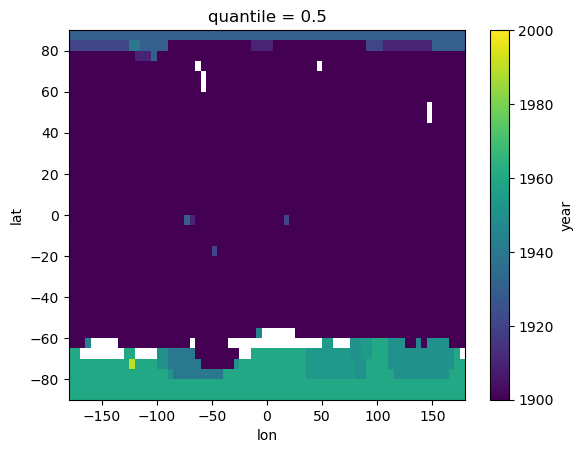

In [175]:
gistemp_startyear_final.plot(vmin=1900,vmax=2000)


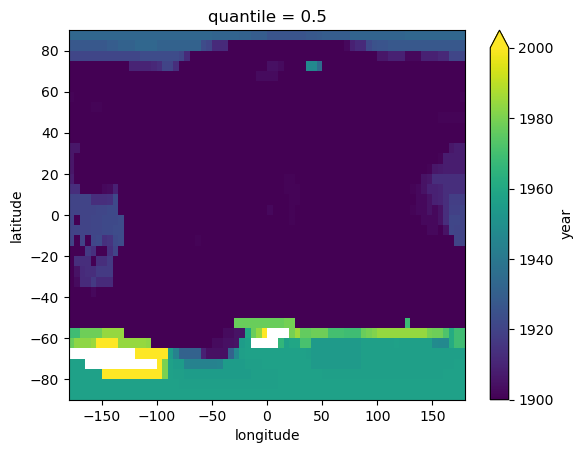

In [176]:
hadcrut5_startyear_final.plot(vmin=1900,vmax=2000)

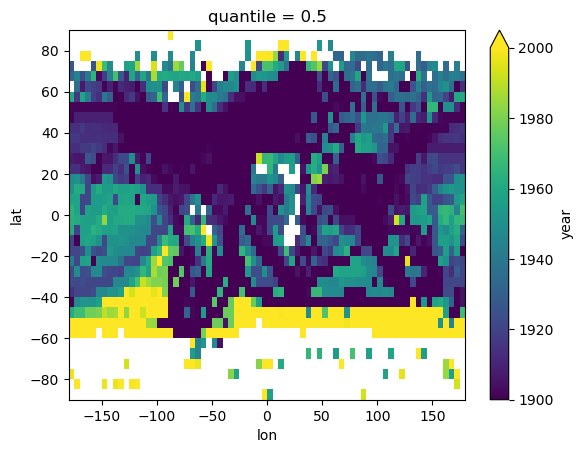

In [51]:
dcent_unfilled_startyear_final.plot(vmin=1900, vmax=2000)

In [119]:
def select_and_pad(
    data: xr.DataArray,
    in_dim: str, 
    out_dim: str, 
    startyear: int,
    durations: np.ndarray,
):
    
    print(type(data))
    print(data.shape)
    print(data)
    subset = data.sel({in_dim: slice(startyear, None)})
    subset_padded = subset.pad({in_dim: (0, len(data[in_dim]) - len(subset[in_dim]))})
    subset_padded = subset_padded.rename({in_dim: out_dim}).assign_coords({out_dim: durations})
    
    return subset_padded


def vectorized_reindex(
    data,
    in_dim,
    out_dim,
    startyear,
    durations,
):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
        
    regressed_month = xr.apply_ufunc(
        select_and_pad, 
        data, in_dim, out_dim, startyear, durations,
        input_core_dims=[[in_dim], [in_dim], [in_dim], [in_dim], [in_dim]],
        output_core_dims=[[out_dim]],
        # vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [ ]:
# gistemp_reindexed.to_netcdf(f"{obslens_tseries_dir}/GISTEMP_5x5/20240820/xagg/ensembleChunks_0001_0200.reindexed.IPCCRegions.190001-202012.nc")

Disagreement between

Text(0, 0.5, 'SST Anomaly (deg. C)')

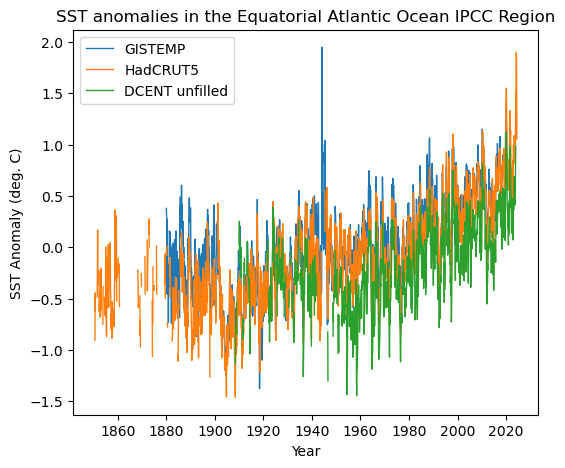

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(
    _gistemp_ds["time"],
    _gistemp_ds.sel(RegionIndex=51).squeeze(),
    label="GISTEMP",
    linewidth=1,
)
ax.plot(
    _hadcrut5_ds["time"],
    _hadcrut5_ds.sel(RegionIndex=51).squeeze(),
    label="HadCRUT5",
    linewidth=1,
)
ax.plot(
    _dcent_ds["time"],
    _dcent_ds.sel(RegionIndex=51).squeeze(),
    label="DCENT unfilled",
    linewidth=1,
)

plt.legend()

plt.title("SST anomalies in the Equatorial Atlantic Ocean IPCC Region")

ax.set_xlabel("Year")
ax.set_ylabel("SST Anomaly (deg. C)")